In [2]:
!pip install datasets pinecone-client[grpc] facenet-pytorch requests pillow

   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------- ----------------------- 0.8/1.9 MB 3.4 MB/s eta 0:00:01
   --------------------------------- ------ 1.6/1.9 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.6 MB 4.2 MB/s eta 0:00:01
   ----------------------- ---------------- 1.6/2.6 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 4.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/4.3 MB ? eta -:--:--
   ------- -------------------------------- 0.8/4.3 MB 4.2 MB/s eta 0:00:01
   ------------------- -------------------- 2.1/4.3 MB 5.1 MB/s eta 0:00:01
   ------------------------ --------------- 2.6/4.3 MB 4.6 MB/s eta 0:00:01
   ------------------------------- -----

In [5]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"


In [7]:
!pip install ipywidgets


  Using cached fqdn-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached uri_template-1.3.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached webcolors-24.11.1-py3-none-any.whl.metadata (2.2 kB)


In [11]:
from datasets import load_dataset

# Load the dataset
celeb_faces = load_dataset("ashraq/tmdb-people-image", split="train")
celeb_faces


Dataset({
    features: ['adult', 'also_known_as', 'biography', 'birthday', 'deathday', 'gender', 'homepage', 'id', 'imdb_id', 'known_for_department', 'name', 'place_of_birth', 'popularity', 'profile_path', 'image'],
    num_rows: 116403
})

In [13]:
celeb=celeb_faces[10]
celeb

{'adult': False,
 'also_known_as': "['Thomas Stanley Holland', 'Том Холланд', 'トム・ホランド', '톰 홀랜드', 'توم هولاند', 'ทอม ฮอลแลนด์', '汤姆·赫兰德', 'Τομ Χόλαντ', 'Том Голланд', '湯姆·霍蘭德', 'טום הולנד', 'תומאס סטנלי הולנד', 'Nhện Đệ Tam', 'ტომ ჰოლანდი']",
 'biography': 'Thomas "Tom" Stanley Holland is an English actor and dancer. He is best known for playing Peter Parker / Spider-Man in the Marvel Cinematic Universe and has appeared as the character in six films: Captain America: Civil War (2016), Spider-Man: Homecoming (2017), Avengers: Infinity War (2018), Avengers: Endgame (2019), Spider-Man: Far From Home (2019), and Spider-Man: No Way Home (2021). He is also known for playing the title role in Billy Elliot the Musical at the Victoria Palace Theatre, London, as well as for starring in the 2012 film The Impossible.',
 'birthday': '1996-06-01',
 'deathday': None,
 'gender': 2,
 'homepage': None,
 'id': 1136406,
 'imdb_id': 'nm4043618',
 'known_for_department': 'Acting',
 'name': 'Tom Holland',
 '

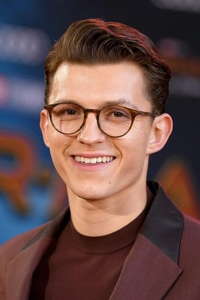

In [15]:
celeb["image"].resize((200,300))

In [17]:
# remove metadata fields not needed, convert into a pandas dataframe
metadata = celeb_faces.remove_columns(['adult', 'also_known_as', 'biography', 'deathday', 'gender', 'homepage', 'id', 'imdb_id', 'known_for_department', 'image']).to_pandas()
# replace any empty fields with None
metadata = metadata.fillna("None")

In [ ]:
from facenet_pytorch import MTCNN

# initialize the MTCNN model
mtcnn = MTCNN()
# create a copy of the face
img = celeb["image"].copy()
# detect face and get coordinates 

In [ ]:
of the face with probability
boxes, prob = mtcnn.detect(img)
boxes, prob

(array([[96.16521453857422, 117.87002563476562, 318.56634521484375,
         405.943359375]], dtype=object),
 array([0.9999951124191284], dtype=object))

In [21]:
if boxes is None:
    print("No face detected!")
else:
    print(f"Face detected with confidence: {prob[0]}")


Face detected with confidence: 0.9999951124191284


In [23]:
if boxes is not None:
    best_index = prob.argmax()  # Get the most confident face
    best_box = boxes[best_index]


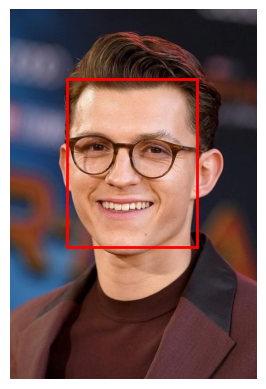

In [25]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Convert image to RGB (in case it's not)
img_rgb = img.convert("RGB")

# Draw bounding box if a face is detected
if boxes is not None:
    plt.imshow(img_rgb)
    ax = plt.gca()
    for (x_min, y_min, x_max, y_max) in boxes:
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             fill=False, color="red", linewidth=2)
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()
else:
    print("No face detected!")


In [27]:
face = mtcnn(img)
face.shape


torch.Size([3, 160, 160])

In [29]:
from facenet_pytorch import InceptionResnetV1
import torch

# initialize VGGFace2 model
resnet = InceptionResnetV1(pretrained="vggface2").eval()
# generate embedding for the face extracted using mtcnn above
embedding = resnet(torch.stack([face]))
embedding.shape

  0%|          | 0.00/107M [00:00<?, ?B/s]

torch.Size([1, 512])

In [31]:
class FacenetEmbedder:
    def __init__(self):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.mtcnn = MTCNN(device=self.device)
        self.resnet = InceptionResnetV1(pretrained='vggface2').eval().to(self.device)

    def encode(self, batch):
        embeddings = []
        valid_indices = []
        for idx, img in enumerate(batch):
            try:
                face = self.mtcnn(img)
                if face is not None:
                    aligned = face.unsqueeze(0).to(self.device)
                    emb = self.resnet(aligned).detach().cpu().squeeze().tolist()
                    embeddings.append(emb)
                    valid_indices.append(idx)
            except Exception as e:
                print(f"Error processing image {idx}: {e}")
        return embeddings, valid_indices


In [33]:
# initialize the embedding pipeline
facenet = FacenetEmbedder()

In [35]:
# test the pipeline using a small image batch
batch = celeb_faces[10:20]["image"]
len(facenet.encode(batch))

2

In [37]:
def reshape(batch):
    batch = [image.convert("RGB").resize((421, 632)) for image in batch]
    return batch

In [39]:
!pip uninstall -y pinecone-client
!pip install --upgrade pinecone



Found existing installation: pinecone-client 6.0.0
Uninstalling pinecone-client-6.0.0:
  Successfully uninstalled pinecone-client-6.0.0


In [41]:
from pinecone import Pinecone, ServerlessSpec

# Initialize Pinecone client
pc = Pinecone(api_key="pcsk_ZcrRL_4GAFwy3C6NudScTsSzPaVDArFniy36zbSoVxw6qSYgpTdodeDnstZjazDnFHmh2")

index_name = "tmdb-people"

# Check if index exists, otherwise create it
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=512,  # must match the embedding size
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",        # or 'gcp'
            region="us-east-1"  # check Pinecone console if unsure
        )
    )

# Connect to the index
index = pc.Index(index_name)

# Verify
print(index.describe_index_stats())


{'dimension': 512,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 36850}},
 'total_vector_count': 36850,
 'vector_type': 'dense'}


In [46]:
from tqdm.auto import tqdm
import pickle
import os
from IPython.display import FileLink  # 👈 For download link in Jupyter

batch_size = 64
all_vectors = []

for i in tqdm(range(0, len(celeb_faces), batch_size)):
    i_end = min(i + batch_size, len(celeb_faces))
    batch = celeb_faces[i:i_end]["image"]
    batch = reshape(batch)

    emb, valid_indices = facenet.encode(batch)
    actual_indices = [i + j for j in valid_indices]
    ids = [f"{idx}" for idx in actual_indices]
    meta = metadata.iloc[actual_indices].to_dict(orient="records")

    to_upsert = list(zip(ids, emb, meta))

    if to_upsert:
        _ = index.upsert(vectors=to_upsert)
        all_vectors.extend(to_upsert)

        # ✅ Save progress after each successful batch
        with open("all_embeddings.pkl", "wb") as f:
            pickle.dump(all_vectors, f)

        # ✅ Show progress percentage
        percent_done = (i_end / len(celeb_faces)) * 100
        print(f"✅ {percent_done:.2f}% completed")

# ✅ Show a link to download the file in Jupyter
print("✅ Embeddings saved! Click the link below to download:")
FileLink("all_embeddings.pkl")


  0%|          | 0/1819 [00:00<?, ?it/s]

✅ 0.05% completed
✅ 0.11% completed
✅ 0.16% completed
✅ 0.22% completed
✅ 0.27% completed
✅ 0.33% completed
✅ 0.38% completed
✅ 0.44% completed
✅ 0.49% completed
✅ 0.55% completed
✅ 0.60% completed
✅ 0.66% completed
✅ 0.71% completed
✅ 0.77% completed
✅ 0.82% completed
✅ 0.88% completed
✅ 0.93% completed
✅ 0.99% completed
✅ 1.04% completed
✅ 1.10% completed
✅ 1.15% completed
✅ 1.21% completed
✅ 1.26% completed
✅ 1.32% completed
✅ 1.37% completed
✅ 1.43% completed
✅ 1.48% completed
✅ 1.54% completed
✅ 1.59% completed
✅ 1.65% completed
✅ 1.70% completed
✅ 1.76% completed
✅ 1.81% completed
✅ 1.87% completed
✅ 1.92% completed
✅ 1.98% completed
✅ 2.03% completed
✅ 2.09% completed
✅ 2.14% completed
✅ 2.20% completed
✅ 2.25% completed
✅ 2.31% completed
✅ 2.36% completed
✅ 2.42% completed
✅ 2.47% completed
✅ 2.53% completed
✅ 2.58% completed
✅ 2.64% completed
✅ 2.69% completed
✅ 2.75% completed
✅ 2.80% completed
✅ 2.86% completed
✅ 2.91% completed
✅ 2.97% completed
✅ 3.02% completed
✅ 3.08% co

C:\Users\RELINCE\all_embeddings.pkl

In [47]:
from IPython.core.display import HTML


def display_result(metadata):
    figures = []
    for m in metadata:
        figures.append(f'''
            <figure style="margin: 5px !important;">
                <img src="https://image.tmdb.org/t/p/h632/{m["profile_path"]}" style="width: 190px; height: 240px; border-radius: 10px;" >
                <figcaption>{m["name"]}</figcaption>
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

In [48]:
def find_similar_faces(face, top_k=10):
    # pass the image through the embedding pipeline
    emb = facenet.encode([face])
    # query pinecone with the face embedding
    result = index.query(vector=emb[0], top_k=6, include_metadata=True)
    # extract metadata from the search results and display results
    r = [x["metadata"] for x in result["matches"]]
    return display_result(r)

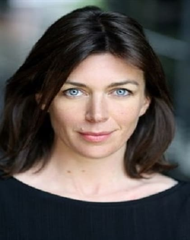

In [49]:
celeb = celeb_faces[40]["image"]
celeb.resize((190,240))

In [50]:
find_similar_faces(celeb)

In [51]:
celeb = celeb_faces[64]["image"]
find_similar_faces(celeb)

In [52]:
from PIL import Image
import requests

def get_image(url):
  img = Image.open(requests.get(url, stream=True).raw)
  return img


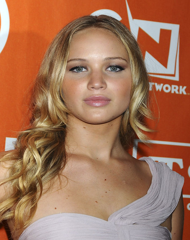

In [53]:
url = "https://live.staticflickr.com/7442/9509564504_21d2dc42e1_z.jpg"
# load the image as PIL object from url
celeb = get_image(url)
celeb.resize((190,240))

In [54]:
find_similar_faces(celeb)

In [ ]:
!pip install streamlit -q
!wget -q -O - ipv4.icanhazip.com  # shows your public IP (optional)
!streamlit run app.py & npx localtunnel --port 8501


'wget' is not recognized as an internal or external command,
operable program or batch file.
